# Deep learning and AI methods
## Session 5: Analyzing image data using convolution neural networks
* Instructor: [Krzysztof Podgorski](https://krys.neocities.org),  [Statistics, Lund University, LUSEM](https://www.stat.lu.se/)
* For more information visit the [CANVAS class website](https://canvas.education.lu.se/courses/1712).

In this session you are ask to run the following Notebook in which convolution neural networks are used to analyse previously studied data set.

### Main Task:

Run the following code. Then explore on your own differented features of the presented tools. At the end of the notebook summarize what did you explore and draw some conclusions from your finding. This summary should not be longer than one page equivalent of a regular text. 

# Image Classification with Convolutional Neural Networks

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
# Just something I need to set up to make fitting work without kernel dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Import the Fashion MNIST dataset

In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Check if the data are there

Let's plot an image to see what it looks like.

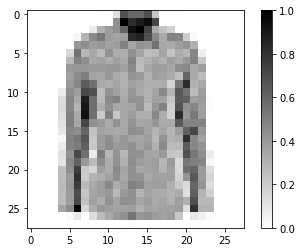

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [11]:
# Setting up a model with 5 hidden layers of different types and nr of nodes
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [12]:
# Setting up the same compiler as we've used before
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
from tensorflow import keras

# Defining the PrintDot class in order to make the output more compact
# while still being able to view the fitting process
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [15]:
model.fit(train_dataset,
          epochs=10,
          steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
          verbose=0,
          callbacks=[PrintDot()])


..........

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

*Comment*: Since I choose not to have the training process displayed, I can't actually see the train accuracy. Instead I should have saved the output from the fitting process into a history object, like we did in lab 4. I'll keep this in mind for the coming tasks.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 20s 64ms/step - loss: 0.2907 - accuracy: 0.9177
Accuracy on test dataset: 0.9177


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Task 1:

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10, activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

 Adjusting the epochs value for the CNN

I create a new model with the same model architecture as above, as otherwise Python will remember the training. Thus, one could not get a proper insight on how adjusting the epochs value will affect the model performance.

#### Solution
So what I'm going to do now is experiment a little bit with some different parts of the neural networks. I'll mark the different experiments with new headlines so as to make it easier to follow what I'm doing. Some of it is code that was already included in this notebook, while some of it will be my own.

#### Changing the number of epochs to 1

In [17]:
# Specifying a new model to see what happens when we train with 1 epoch
model_new = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Fitting the model with one epoch
history1 = model_new.fit(train_dataset,
                    epochs=1,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])
print('\nAccuracy:', history1.history['accuracy'])


.
Accuracy: [0.90595]


In [20]:
test_loss1, test_accuracy1 = model_new.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy1)

313/313 [==============================] - 7s 23ms/step - loss: 0.2586 - accuracy: 0.9068
Accuracy on test dataset: 0.9068


*Comment*: The train accuracy with just one epoch is 85,78%, which is lower than before (97%). That makes sense, since the network basically wasn't given the chance to adjust it's predictions and get better at the task. It's still really high though!

#### Number of neurons in the last hidden layer
Here I'll try and see what happens when we adjust the number of nodes in the Dense layer that comes after the Faltten-layer in the original architecture. I'll use 5 epochs for training to save time since the models take quite long to run on my computer.

In [21]:
# Training a model with only 10 nodes in the last hidden layer

# Define model
model10 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

# Compile model
model10.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit model
history10 = model10.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

# Test model
test_loss10, test_accuracy10 = model10.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', history10.history['accuracy'][np.max(history10.epoch)])
print('Test accuracy:', test_accuracy10)


313/313 [==============================] - 7s 24ms/step - loss: 0.2743 - accuracy: 0.9046

Train accuracy: 0.91678333
Test accuracy: 0.9046


In [22]:
# Training a model with 220 nodes in the last hidden layer

# Define model
model220 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(220, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

# Compile model
model220.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit model
history220 = model220.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

# Test model
test_loss220, test_accuracy220 = model220.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', history220.history['accuracy'][np.max(history220.epoch)])
print('Test accuracy:', test_accuracy220)


313/313 [==============================] - 6s 21ms/step - loss: 0.2610 - accuracy: 0.9132

Train accuracy: 0.9467667
Test accuracy: 0.9132


In [23]:
# Training a model with 512 nodes in the last hidden layer

# Define model
model512 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

# Compile model
model512.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit model
history512 = model512.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

# Test model
test_loss512, test_accuracy512 = model512.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', history512.history['accuracy'][np.max(history512.epoch)])
print('Test accuracy:', test_accuracy512)


313/313 [==============================] - 8s 27ms/step - loss: 0.2872 - accuracy: 0.8967

Train accuracy: 0.91915
Test accuracy: 0.8967


<BarContainer object of 3 artists>

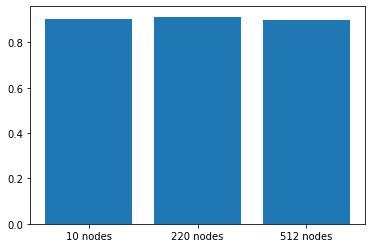

In [24]:
# Plotting the accuracy rates for comparison
y = [test_accuracy10, test_accuracy220, test_accuracy512]
x = ['10 nodes', '220 nodes', '512 nodes']
plt.bar(x, y)

*Comment*: As we can see in the figure above, adjusting the node size doesn't really make much of a difference. More nodes does not mean higher accuracy for this task, which we can see if we look at the accuracy of the network with 512 nodes.

*Note*: Adding additional dense layers and trying on unnormalized data seems to be placed under the next task even though it was stated in task 1. So I will do them there, together with adjusting and experimenting with more models. In the end I will try to compare all of them. 

## Task 2:

Experiment with at least two more models that involve the convolution in one layer. Make the fit of your models and compare the accuracy betweem the model. Make predictions and explore the models. Illustrate your findings and comment. Comapare with the results to other methods explored in the previous labs on this data set. DO NOT experiment with cross-validation as it can be computationally too expensive for the convolution considered models. 

#### Adjusting the architecture of the CNN

In [25]:
# Set up different model architectures of the CNN
# Model 2: 50 Units in the hidden layer

modelarch2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelarch2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyarch2 = modelarch2.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossarch2, test_accuracyarch2 = modelarch2.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyarch2.history['accuracy'][np.max(historyarch2.epoch)])
print('Test accuracy:', test_accuracyarch2)


313/313 [==============================] - 6s 18ms/step - loss: 0.2430 - accuracy: 0.9154

Train accuracy: 0.93541664
Test accuracy: 0.9154


In [26]:
# Model with one more pooling and Conv2D layer

modelarch3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelarch3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyarch3 = modelarch3.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossarch3, test_accuracyarch3 = modelarch3.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyarch3.history['accuracy'][np.max(historyarch3.epoch)])
print('Test accuracy:', test_accuracyarch3)


313/313 [==============================] - 6s 20ms/step - loss: 0.2534 - accuracy: 0.9096

Train accuracy: 0.92135
Test accuracy: 0.9096


In [27]:
# Model with one less pooling and Conv2D layer

modelarch4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelarch4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyarch4 = modelarch4.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossarch4, test_accuracyarch4 = modelarch4.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyarch4.history['accuracy'][np.max(historyarch4.epoch)])
print('Test accuracy:', test_accuracyarch4)


313/313 [==============================] - 4s 13ms/step - loss: 0.2702 - accuracy: 0.9072

Train accuracy: 0.92838335
Test accuracy: 0.9072


<BarContainer object of 3 artists>

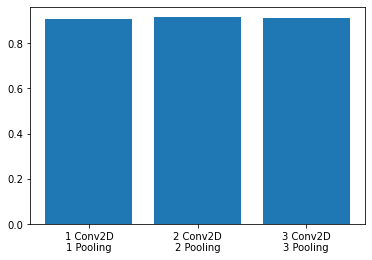

In [28]:
# Plotting the accuracy rates for comparison
y = [test_accuracyarch4, test_accuracyarch2, test_accuracyarch3]
x = ['1 Conv2D\n1 Pooling', '2 Conv2D\n2 Pooling', '3 Conv2D\n3 Pooling']
plt.bar(x, y)

*Comment*: Again we can see that more complexity doeasn't really contribute to higher accuracy. Compared to the setup in the first model, we can even take away one set of Conv2D and Pooling layers and still achieve the same test accuracy.

#### Adding additional dense layers

In [29]:
# 2 hidden layers
modelA = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelA.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyA = modelA.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossA, test_accuracyA = modelA.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyA.history['accuracy'][np.max(historyA.epoch)])
print('Test accuracy:', test_accuracyA)


313/313 [==============================] - 6s 18ms/step - loss: 0.2382 - accuracy: 0.9132

Train accuracy: 0.9332167
Test accuracy: 0.9132


In [30]:
# 4 hidden layers
modelB = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelB.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyB = modelB.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossB, test_accuracyB = modelB.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyB.history['accuracy'][np.max(historyB.epoch)])
print('Test accuracy:', test_accuracyB)


313/313 [==============================] - 7s 22ms/step - loss: 0.2933 - accuracy: 0.8923

Train accuracy: 0.91926664
Test accuracy: 0.8923


In [31]:
# 8 hidden layers
modelC = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

modelC.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

historyC = modelC.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_lossC, test_accuracyC = modelC.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', historyC.history['accuracy'][np.max(historyC.epoch)])
print('Test accuracy:', test_accuracyC)


313/313 [==============================] - 6s 20ms/step - loss: 0.3225 - accuracy: 0.8866

Train accuracy: 0.89073336
Test accuracy: 0.8866


<BarContainer object of 3 artists>

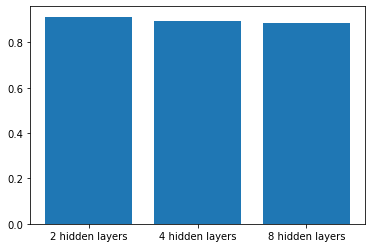

In [32]:
# Plotting the accuracy rates for comparison
y = [test_accuracyA, test_accuracyB, test_accuracyC]
x = ['2 hidden layers', '4 hidden layers', '8 hidden layers']
plt.bar(x, y)

*Comment*: Once again, adding complexity has is not contributing to accuracy. Accuracy even decreases as we increade the number of hidden layers.

#### Unnormalized pixel values

In [33]:
#Download the data again, but this time storing it as dataset2
dataset2, metadata2 = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset2, test_dataset2 = dataset2['train'], dataset2['test']

In [34]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [35]:
num_train_examples2 = metadata2.splits['train'].num_examples
num_test_examples2 = metadata2.splits['test'].num_examples
print("Number of training examples in dataset2: {}".format(num_train_examples2))
print("Number of test examples in dataset2:     {}".format(num_test_examples2))

Number of training examples in dataset2: 60000
Number of test examples in dataset2:     10000


In [36]:
# Keep in memory
train_dataset2 =  train_dataset2.cache()
test_dataset2  =  test_dataset2.cache()

In [37]:
# Shuffle and split into batches
BATCH_SIZE = 32
train_dataset2 = train_dataset2.repeat().shuffle(num_train_examples2).batch(BATCH_SIZE)
test_dataset2 = test_dataset2.batch(BATCH_SIZE)

For comparison reasons, I just train the unnormalized dataset with the very first model with 128 hidden units and one hidden layer.

In [38]:
model_unscaled = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model_unscaled.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_unscaled = model_unscaled.fit(train_dataset2,
                    epochs=5,
                    steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_loss_unscaled, test_accuracy_unscaled = model_unscaled.evaluate(test_dataset2, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', history_unscaled.history['accuracy'][np.max(history_unscaled.epoch)])
print('Test accuracy:', test_accuracy_unscaled)


313/313 [==============================] - 19s 60ms/step - loss: 0.3080 - accuracy: 0.9023

Train accuracy: 0.92481667
Test accuracy: 0.9023


*Comment*: I can't see much of a difference here, to be honest. But I know it's supposed to take more training for the network to find the right parameters. However, since I'm constantly working with 5 epochs to reduce the time it takes to train each network, that might be why I can't really see the difference.

## Task 3: 

Use the reduced data set with 4 x 4 pixels and check the performance of your preferred convolution neural network on the reduced data set. Compare with all the previous results and comment. 

*Comment*: In order to do this, I first need to load the data anew to get it into the dimensions that I've used on previous labs when reducing the number of dimensions. Then I reduce the dimensions to 4, and then I run a model on that data.

In [39]:
# Load data
dataset3, metadata3 = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset3, test_dataset3 = dataset3['train'], dataset3['test']

In [40]:
# Keep in memory
train_dataset3 =  train_dataset3.cache()
test_dataset3  =  test_dataset3.cache()

In [41]:
# Normalize the data
train_dataset3 =  train_dataset3.map(normalize)
test_dataset3  =  test_dataset3.map(normalize)

In [42]:
# Stating function for dimension reduction
def reduce_size(images, labels):
  images = tf.image.resize(images, [4,4])
  return images, labels

In [43]:
# Reduce the size to 4x4
train_dataset_reduced = train_dataset3.map(reduce_size)
test_dataset_reduced = test_dataset3.map(reduce_size)

[[0.         0.         0.33333334 0.        ]
 [0.         0.5686275  0.2784314  0.        ]
 [0.         0.41568628 0.30980393 0.        ]
 [0.         0.         0.30980393 0.        ]]


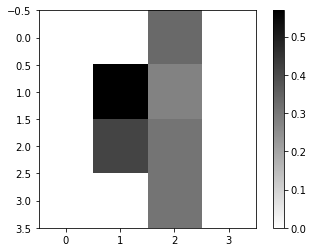

In [44]:
# Take a single image, and remove the color dimension by reshaping
for image, label in train_dataset_reduced.take(1):
  break
image = image.numpy().reshape((4,4))
print(image)

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

[[0.         0.38431373 0.33333334 0.        ]
 [0.         0.42352942 0.4627451  0.        ]
 [0.         0.44705883 0.45882353 0.        ]
 [0.         0.42745098 0.34901962 0.        ]]


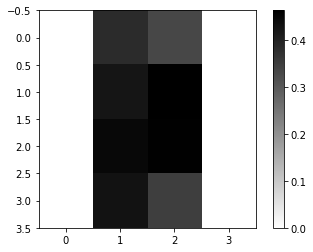

In [45]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset_reduced.take(1):
  break
image = image.numpy().reshape((4,4))
print(image)

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

*Comment*: As we can see above, the size reduction isn't keeping the information (as we as humans know it) very well when we only use 4x4. It will be interesting to see if there is a pattern that the network can detect.

In [46]:
# Shuffle and create batches
BATCH_SIZE = 32
train_dataset_reduced = train_dataset_reduced.repeat().shuffle(metadata3.splits['train'].num_examples).batch(BATCH_SIZE)
test_dataset_reduced = test_dataset_reduced.batch(BATCH_SIZE)

*Comment*: Drawing on the experience from the previous experiments, I will build a model for the 4x4 data that is aimed to be as non-complex as possible. For example, I'll only use one Covd2D layer and one pooling layer. The last hidden layer will only have 20 nodes. 

In [47]:
# Build model
model4x4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(4, 4, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model4x4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history4x4 = model4x4.fit(train_dataset_reduced,
                    epochs=5,
                    steps_per_epoch=math.ceil(metadata3.splits['train'].num_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

test_loss4x4, test_accuracy4x4 = model4x4.evaluate(test_dataset_reduced, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', history4x4.history['accuracy'][np.max(history4x4.epoch)])
print('Test accuracy:', test_accuracy4x4)


313/313 [==============================] - 19s 60ms/step - loss: 1.0299 - accuracy: 0.5963

Train accuracy: 0.60445
Test accuracy: 0.5963


*Comment*: It turns out that the network is quite bad at dealing with the data. The accuracy is a lot lower than for the models trained with examples of 28*28 pixel images.

In [51]:
history1.history['accuracy']

[0.90595]

In [52]:
# Finding the highest train accuracy amongst all models
all_train_accuracy = [[0.97],
                      history1.history['accuracy'],
                      history10.history['accuracy'][np.max(history10.epoch)],
                      history220.history['accuracy'][np.max(history220.epoch)],
                      history512.history['accuracy'][np.max(history512.epoch)],
                      historyarch2.history['accuracy'][np.max(historyarch2.epoch)],
                      historyarch3.history['accuracy'][np.max(historyarch3.epoch)],
                      historyarch4.history['accuracy'][np.max(historyarch4.epoch)],
                      historyA.history['accuracy'][np.max(historyA.epoch)],
                      historyB.history['accuracy'][np.max(historyB.epoch)],
                      historyC.history['accuracy'][np.max(historyC.epoch)],
                      history_unscaled.history['accuracy'][np.max(history_unscaled.epoch)],
                      history4x4.history['accuracy'][np.max(history4x4.epoch)]]

print('Highest train accuracy was:', np.max(np.array(all_train_accuracy)))
print('It came from the model on list place:', np.argmax(np.array(all_train_accuracy)))

Highest train accuracy was: [0.97]
It came from the model on list place: 0


/Users/Sara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/Users/Sara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/Users/Sara/anaconda3/lib/python3.7/site-packages/numpy/lib/stride_tricks.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


<BarContainer object of 13 artists>

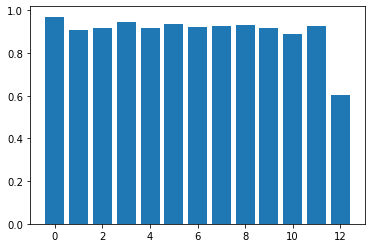

In [55]:
plt.bar(range(len(all_train_accuracy)), height = all_train_accuracy)

In [57]:
# Finding the highest test accuracy amongst all models
all_test_accuracy = [test_accuracy,
                     test_accuracy1,
                     test_accuracy10,
                     test_accuracy220,
                     test_accuracy512,
                     test_accuracyarch2,
                     test_accuracyarch3,
                     test_accuracyarch4,
                     test_accuracyA,
                     test_accuracyB,
                     test_accuracyC,
                     test_accuracy_unscaled,
                     test_accuracy4x4]

print('Highest test accuracy was:', np.max(all_test_accuracy))
print('It came from the model on list place:', np.argmax(all_test_accuracy))

Highest test accuracy was: 0.9177
It came from the model on list place: 0


<BarContainer object of 13 artists>

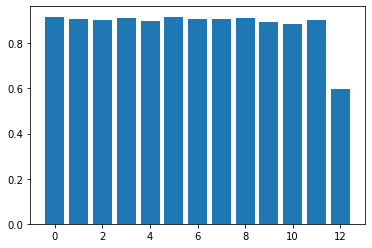

In [59]:
plt.bar(range(len(all_test_accuracy)), height = all_test_accuracy)

*Comment*: All models performed very equally, apart from the last one which was trained and tested on the low dim data. The very first model specified performed best in all cases, however, it was also trained with more epochs, so that might be why. To compare, I'll try my last model on the high-dimensional data and train it for 10 epochs.

In [60]:
# Build model
last_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

last_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

last_history = last_model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=math.ceil(metadata3.splits['train'].num_examples/BATCH_SIZE),
                    verbose=0,
                    callbacks=[PrintDot()])

last_test_loss, last_test_accuracy = last_model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

# Print accuracy
print('\nTrain accuracy:', last_history.history['accuracy'][np.max(last_history.epoch)])
print('Test accuracy:', last_test_accuracy)


313/313 [==============================] - 3s 10ms/step - loss: 0.2744 - accuracy: 0.9110

Train accuracy: 0.94406664
Test accuracy: 0.911


### Summary (as per requested as the main task)
In this notebook I have built several deep learning models with the aim of classifying images of clothes. All models have performed with a very high accuracy, apart from the model trained and tested on low dimensional data. This is expected, since the NN structure makes very good use of high dimensional data and can detect patterns that other algorithms can't. Still though, a 59 % test accuracy on that data is surprisngly high, given that a naive chance classifier would only be expected to be right 10 % of the time due to the 10 categories.

My overall impression from my experiments are that more complex network doesn't really (at least nessecerily) contribute to higher accuracy. However, too little complexity can reduce accuracy. This was shown in my last network, where I kept the complecity at a minimum (fewer nodes in last hidden layer, one one set of Conv2D + Pooling layers, etc.) while still using the full-dimensional data. This network didn't perform better than the original model, and only slightly better than most other models tried in this lab.

Naturally, these results aren't very stable because they risk being very affected by the randomness of what we get in the train vs test data. From before, in previous labs, we know for example that the NN can be bad at predicting a sneaker if it is turned in the other direction on the picture, compared to the other sneakers. Since there are fewer examples on the sneaker turned in the "wrong" direction, we are more sensitive to where those pictures end up with regards to training and test set. As such, it is always better to cross-validate. In this case however, it was very clear that it was not possible to do cross-validation since it would've taken a veeery long time.

In conclusion, neural networks are quite cool since they can obviously rather easily be trained to do a good job at classifying images, which "normal" statistical models often can't.

## Grader box: 

In what follows the grader will put the values according the following check list:

* 1 Have all commands included in a raw notebook been evaluated? (0 or 0.5pt)
* 2 Have all commands been experimented with? (0 or 0.5pt)
* 3 Have all experiments been briefly commented? (0 or 0.5pt)
* 4 Have all tasks been attempted? (0, 0.5, or 1pt)
* 5 How many of the tasks have been completed? (0, 0.5, or 1pt)
* 6 How many of the tasks (completed or not) have been commented? (0, 0.5, or 1pt)
* 7 Have been the conclusions from performing the tasks clearly stated? (0, 0.5, or 1pt)
* 8 Have been the overall organization of the submitted Lab notebook been neat and easy to follow by the grader? (0, or 0.5pt) 


#### 1 Have all commands included in a raw notebook been evaluated? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A
#### Grader's comment (if desired): 
N/A

#### 2 Have all commands been experimented with? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A

#### 3 Have all experiments been briefly commented? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A

#### 4 Have all tasks been attempted? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 5 How many of the tasks have been completed? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 6 How many of the tasks (completed or not) have been commented? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 7 Have been the conclusions from performing the tasks clearly stated? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 8 Have been the overall organization of the submitted Lab notebook been neat and easy to follow by the grader? (0, or 0.5pt)

#### Grader's comment (if desired): 
N/A

### Overall score

### Score and grader's comment (if desired): 
N/A